<div style="text-align: center">
  <img src="https://www.dropbox.com/scl/fi/lwqqzp1vwyo67ozhojgrf/7882_with_patches.png?rlkey=apiw1l9cl8edqwt8ew0j7x13f&st=b2xc4k42&dl=1" alt="Image" width=600 height=420 >
</div>






Kaggle Dataset: https://www.kaggle.com/datasets/ubiratanfilho/sds-dataset


Website: https://seadronessee.cs.uni-tuebingen.de/dataset


## Import Dependencies

In [1]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (234 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 121918 files and directories currently install

We will set up our model fine tuning pipeline using torchvision library and torchmetrics with pycocotools for calculating the evaluation metrics.

In [3]:
# !pip install -qq torchvision
# !pip install -qq torch
!pip install -qq torchmetrics[detection]
!pip install -qq pycocotools
!pip install -qq tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 64.5 MB/s eta 0:00:00


To adapt our training code and utilities for torchvision object detection, we will simply clone the official torchvision repository.

In [4]:
!git clone https://github.com/pytorch/vision.git  #Training Metric Utilities from Torchvision

Cloning into 'vision'...
remote: Enumerating objects: 509110, done.
remote: Counting objects: 100% (22720/22720), done.
remote: Compressing objects: 100% (1150/1150), done.
remote: Total 509110 (delta 21594), reused 22609 (delta 21532), pack-reused 486390
Receiving objects: 100% (509110/509110), 990.01 MiB | 32.50 MiB/s, done.
Resolving deltas: 100% (474838/474838), done.


## Import Dependencies

In [4]:
import os
import gc
import json
import math
import random
import requests
import zipfile
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageStat
import PIL
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
import logging
from tqdm import tqdm

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from dataclasses import dataclass
import torchvision
from vision.references.detection import utils

import torchvision.transforms as T
from torchvision.transforms import v2 as Tv2
from torchvision import tv_tensors
from torchvision.transforms import functional as F
from torchvision.transforms.functional import to_pil_image

import torchvision.models.detection as detection
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.transform import GeneralizedRCNNTransform

Let's set seed for reproducibility

In [6]:
def set_seeds():
    # fix random seeds
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
set_seeds()

## **Download Dataset - Preprocessed as patches**

To save time and compute directly, download the patches we created by running the following script. This script skips  the dataset preprocessing function for patch creation.

In [5]:
if not os.path.exists('SeaDroneSee'):
    os.mkdir('SeaDroneSee')

!wget -O SeaDroneSee/SeaDroneSee.zip "https://www.dropbox.com/scl/fi/0oyv9pki57laqgmq7matd/SeaDroneSee.zip?rlkey=yasyxr0u3450dylv5musks1s0&st=q12t3tc3&dl=1"

--2024-05-27 13:22:56--  https://www.dropbox.com/scl/fi/0oyv9pki57laqgmq7matd/SeaDroneSee.zip?rlkey=yasyxr0u3450dylv5musks1s0&st=q12t3tc3&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfe7d930b1f5283f090fc5e44bd.dl.dropboxusercontent.com/cd/0/inline/CTvh4fjkcmE4qf3iU_eRa13wNij7q2_cYyM0hoM_RDHboNFMwBQ4tqWPrJZDCZ2Da-yLARxQ8CnCAJ5ouWv5YbOi18_sGVnNNlZAi20Pe865BAExUCHNKgAOJaabPET8R9NMXx12xDW20FjlgnWf0zW2/file?dl=1# [following]
--2024-05-27 13:22:56--  https://ucfe7d930b1f5283f090fc5e44bd.dl.dropboxusercontent.com/cd/0/inline/CTvh4fjkcmE4qf3iU_eRa13wNij7q2_cYyM0hoM_RDHboNFMwBQ4tqWPrJZDCZ2Da-yLARxQ8CnCAJ5ouWv5YbOi18_sGVnNNlZAi20Pe865BAExUCHNKgAOJaabPET8R9NMXx12xDW20FjlgnWf0zW2/file?dl=1
Resolving ucfe7d930b1f5283f090fc5e44bd.dl.dropboxusercontent.com (ucfe7d930b1f5283f090fc5e44bd.dl.dropboxuserconten

In [40]:
!wget -O SeaDroneSee/SeaDroneSee_test.zip "https://www.dropbox.com/scl/fi/4qidpahgu9mogam33uxlz/SeaDroneSee_test.zip?rlkey=1gt6mebuppxg4ehzhicwqafav&st=5g01mcdb&dl=1"

--2024-05-27 13:50:19--  https://www.dropbox.com/scl/fi/4qidpahgu9mogam33uxlz/SeaDroneSee_test.zip?rlkey=1gt6mebuppxg4ehzhicwqafav&st=5g01mcdb&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7088f9777c15fbc0818ede2af7.dl.dropboxusercontent.com/cd/0/inline/CTsEYdZLRShzbkKLchxyeRfcsEc36-pZ8DANxa9R4Rj1wm-ICz35HHymT5Ym-7mkli-nkqHCozdGQl62RuU2-1UrEJK_gxiMJfDGu7Xv9qKhs1y0ZJ2cqAPZLKV2WxtCtuSPgKZ7asz8U4O-F8iIkf5L/file?dl=1# [following]
--2024-05-27 13:50:19--  https://uc7088f9777c15fbc0818ede2af7.dl.dropboxusercontent.com/cd/0/inline/CTsEYdZLRShzbkKLchxyeRfcsEc36-pZ8DANxa9R4Rj1wm-ICz35HHymT5Ym-7mkli-nkqHCozdGQl62RuU2-1UrEJK_gxiMJfDGu7Xv9qKhs1y0ZJ2cqAPZLKV2WxtCtuSPgKZ7asz8U4O-F8iIkf5L/file?dl=1
Resolving uc7088f9777c15fbc0818ede2af7.dl.dropboxusercontent.com (uc7088f9777c15fbc0818ede2af7.dl.dropboxuserc

If you want to create patches with your choice of patch size,overlap ratio, and the number of patches to be saved, continue with the Patch creation code sections in another Image Patch Creation Notebook attached.

In [6]:
def download_file(url, save_name):
    if not os.path.exists(save_name):
        # Handling potential redirection in requests
        with requests.get(url, allow_redirects=True) as r:
            if r.status_code == 200:
                with open(save_name, 'wb') as f:
                    f.write(r.content)
            else:
                print("Failed to download the file, status code:", r.status_code)

def unzip(zip_file=None, target_dir=None):
    try:
        with zipfile.ZipFile(zip_file, 'r') as z:
            z.extractall(target_dir)
            print("Extracted all to:", target_dir)
    except zipfile.BadZipFile:
        print("Invalid file or error during extraction: Bad Zip File")
    except Exception as e:
        print("An error occurred:", e)

save_path = 'SeaDroneSee/SeaDroneSee.zip'
model_ckpt_url = 'https://www.dropbox.com/scl/fi/xmftrum0a8rgjp82j6n65/model_ckpt.zip?rlkey=aywwl28rbcbiejggdps0durfu&st=dda61bld&dl=1'
model_save_path = 'SeaDroneSee/Model_ckpt.zip'


In [7]:
download_file(model_ckpt_url, model_save_path)
unzip(zip_file=model_save_path, target_dir='SeaDroneSee')  # Specify target directory for the model checkpoint
unzip(zip_file=save_path, target_dir='SeaDroneSee')
test_save_path= 'SeaDroneSee/SeaDroneSee_test.zip'
unzip(zip_file = test_save_path, target_dir='SeaDroneSee')

Extracted all to: SeaDroneSee
Extracted all to: None


In [10]:
!tree --dirsfirst -L 2 "SeaDroneSee/output_patches"

SeaDroneSee/output_patches
├── annotations
│   ├── instances_patches_train.json
│   └── instances_patches_val.json
└── images
    ├── train
    └── val

4 directories, 2 files


### **Utilities**

**Class mapping**

Let's do a class mapping and assign a unique color for each label or class ID.

In [11]:
classes_to_idx = {
    0: 'ignored',
    1: 'swimmer',
    2: 'boat',
    3: 'jetski',
    4: 'life_saving_appliances',
    5: "buoy"
}

# Mapping category IDs to colors
category_colors = {
    0: 'black',   # ignored
    1: 'red',     # swimmer
    2: 'orange',   # boat
    3: 'blue',    # jetski
    4: 'purple',  # life saving appliances
    5: 'yellow'   # buoy
}

Understanding the dataset is a crucial step in any deep-learning task. So, we will spend a good amount of time here on some preprocessing techniques for this dataset.

To inspect and visualize the ground truth annotations, let’s define draw_bounding_boxes' utility. One of the key aspects in object detection is the bounding box format, which can hamper our fine-tuning Faster RCNN pipeline if not properly handled. Our dataset annotations are in XYWH format, so we will convert them to XYXY, which is the expected format of PIL’s Image Draw function.

In [12]:
def draw_bounding_boxes(image, bboxes):
    draw = ImageDraw.Draw(image)
    font_size = int(min(image.size) * 0.02)  # Adjust font size based on image size
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    font = ImageFont.truetype(font_path, font_size) if os.path.exists(font_path) else ImageFont.load_default()

    for bbox, category_id in bboxes:
        x, y, w, h = bbox
        x1, y1, x2, y2 = x, y, x + w, y + h
        color = category_colors.get(category_id, 'white')  # Default to white if category_id is unknown
        draw.rectangle([x1, y1, x2, y2], outline=color, width=4)
        draw.text((x1, y1 - font_size), str(category_id), fill=color, font=font)

    return image


The load_annotations utility takes the path of instances_patches_train.json or instaces_patches_val.json to load them and returns their annotations.


In [13]:
def load_annotations(annotation_path):
    with open(annotation_path, 'r') as f:
         annotations = json.load(f)
    return annotations

After loading, we will iterate over each bounding box with their image ID from the annotations, and using matplotlib, we will plot the ground truth with an arbitrary number of samples of our choice.

In [14]:
# Visualize samples
def visualize_patch_samples(image_dir, annotation_path, num_samples=5):
    annotations = load_annotations(annotation_path)
    images_with_bboxes = {}

    # Collecting image paths and their respective bounding boxes
    for annot in annotations['annotations']:
        image_id = annot['image_id']
        if image_id not in images_with_bboxes:
            images_with_bboxes[image_id] = []
        images_with_bboxes[image_id].append((annot['bbox'], annot['category_id']))

    # Select random samples to visualize
    sampled_images = random.sample(list(images_with_bboxes.keys()), min(num_samples, len(images_with_bboxes)))

    # Visualize samples
    plt.figure(figsize=(15, num_samples * 5))
    for i, image_id in enumerate(sampled_images):
        image_path = os.path.join(image_dir, image_id)
        if not os.path.exists(image_path):
            continue
        image = Image.open(image_path)
        # print(image.size)
        bboxes = images_with_bboxes[image_id]
        image = draw_bounding_boxes(image, bboxes)

        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Image ID: {image_id}")

    plt.tight_layout()
    plt.show()

### **Visualise Patches - Ground Truth**

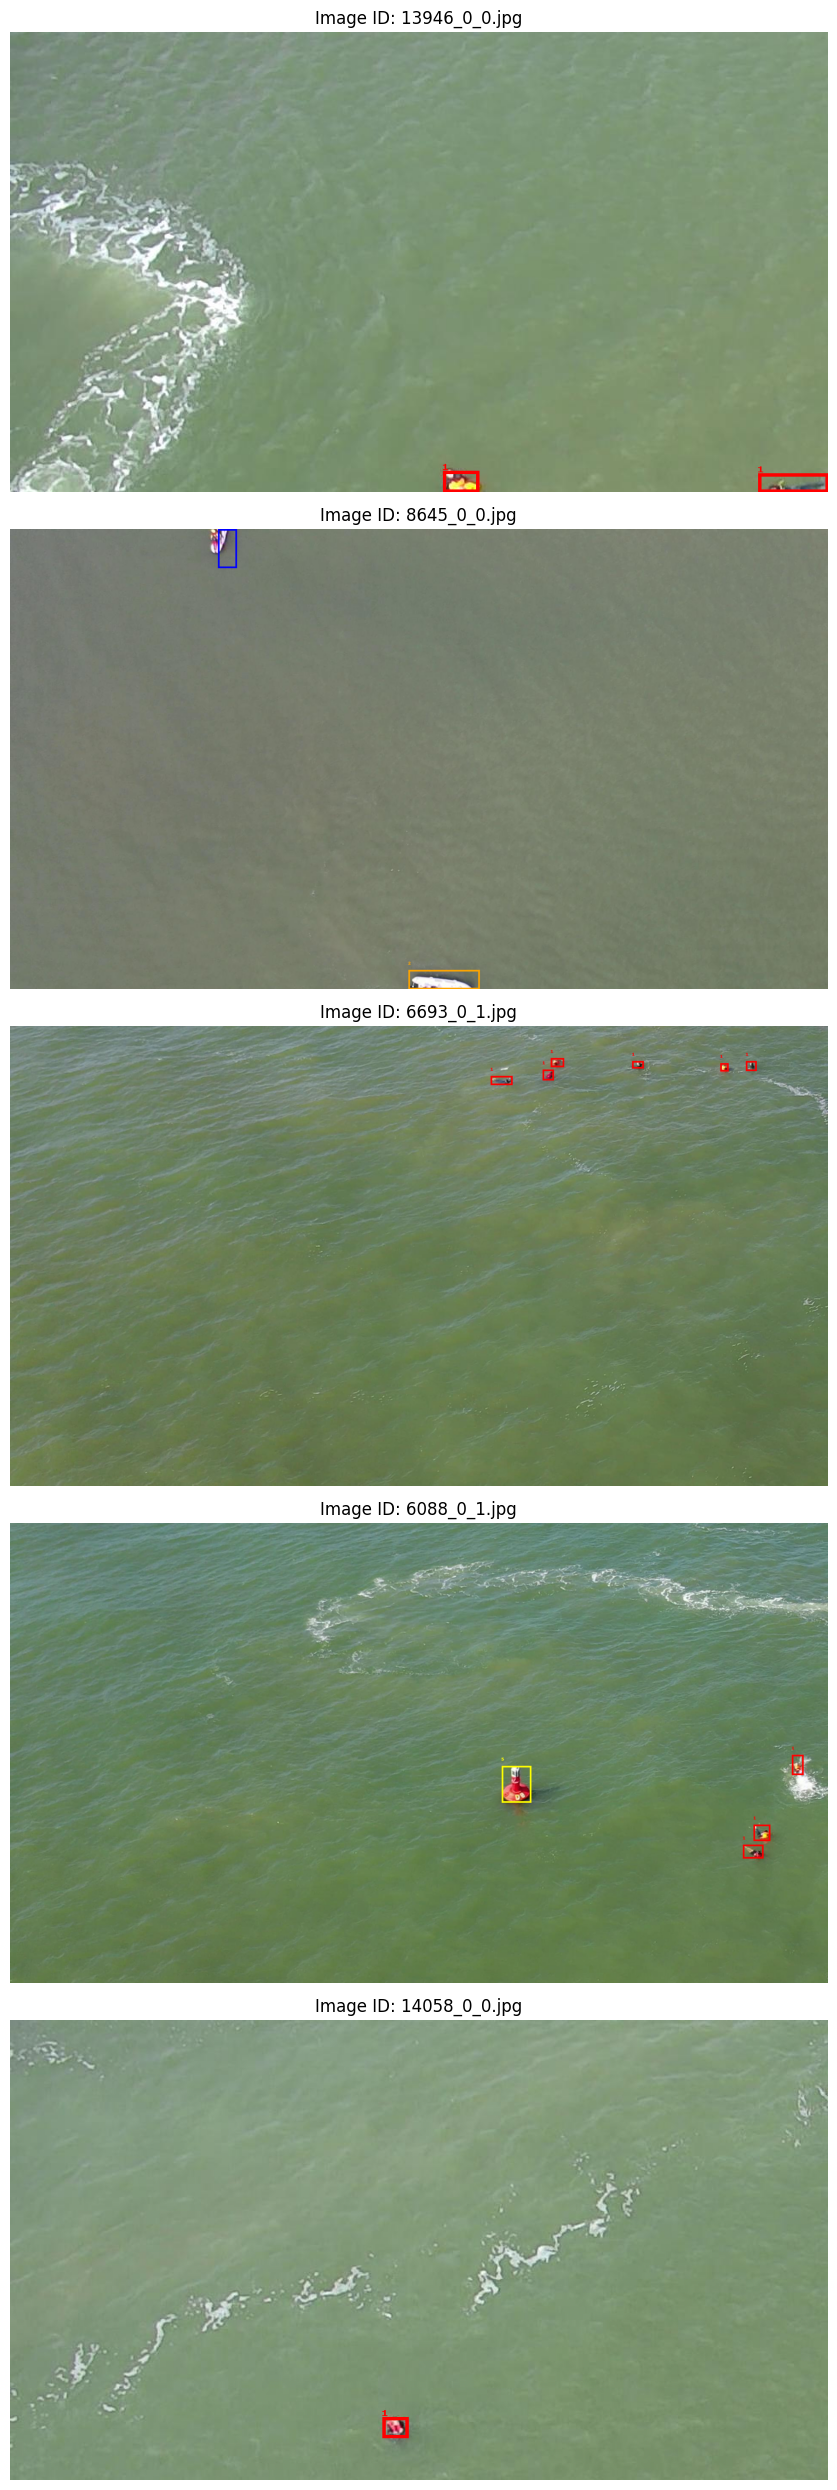

In [16]:
image_dir = 'SeaDroneSee/output_patches/images/val'
annotation_path = 'SeaDroneSee/output_patches/annotations/instances_patches_val.json'

visualize_patch_samples(image_dir,annotation_path,num_samples=5)

## **DataClass Preparation**

This line defines a dataclass named DatasetConfig for storing configuration parameters for a dataset.

In [17]:
@dataclass
class DatasetConfig:
    root: str
    annotations_file: str
    train_img_size: tuple
    subset: str = 'train'  # Default to 'train'
    transforms: any = None

Here the `CustomAerialDataset` class is designed to handle aerial image datasets and perform tasks such as loading images, handling annotations, and preparing data to fine-tuning Faster R-CNN model. 

Below is a brief overview of its key functionalities:

* The class takes a `DatasetConfig` object that contains the root directory, image size, subset (train/val/test), and any transformations.
It initializes paths for images and annotations and calls methods to load them.

*  The `_load_images` method scans the specified subset directory and appends valid image file paths to the `imgs` list.
Each image is given an empty annotation initially.

* Then the `_load_annotations` method reads a JSON file containing bounding box annotations.
It matches each annotation to its corresponding image and stores the bounding box coordinates and category IDs.

 
* The `__getitem__` method retrieves an image and its annotations by index.
It handles missing images by returning a zero tensor and a dummy target if there are no instances within an image. This is done because while enumerating a batch of image and its corresponding target the loss calculation expects a target of shape (N,4). If we just pass the image without an instance this will throw an error like expected a tensor of shape (N,4) but received torch.size([0]).

* Then the image is resized to the specified dimensions, and bounding boxes are scaled accordingly to reduce the training time and GPU hours.
* The target here will be a dictionary of box tensors and their equivalent label tensor of data type float32 and int64 respectively.
  
* Whatever the transformations by torch.transforms.functional will be applied to both image and target to ensure valid augmentation is performed to improve model performance.



In [18]:
class CustomAerialDataset(Dataset):
    def __init__(self, config: DatasetConfig):
        self.root = config.root
        self.transforms = config.transforms
        self.train_img_size = config.train_img_size
        self.subset = config.subset
        self.annotations_file = os.path.join(self.root, 'annotations', f'instances_patches_{self.subset}.json')
        self.imgs = []
        self.img_annotations = {}
        self._load_images()
        self._load_annotations()

    def __len__(self):
        return len(self.imgs)

    def _load_images(self):
        # Load all images from the subset directory
        images_path = os.path.join(self.root, 'images', self.subset)
        for image_filename in os.listdir(images_path):
            image_path = os.path.join(images_path, image_filename)
            if os.path.isfile(image_path) and image_path.endswith(('.png', '.jpg', '.jpeg')):
                self.imgs.append(image_path)
                image_id = os.path.basename(image_path)
                # Initialize empty annotations for each image
                if image_id not in self.img_annotations:
                    self.img_annotations[image_id] = {'boxes': [], 'labels': []}

    def _load_annotations(self):
        with open(self.annotations_file, 'r') as f:
            data = json.load(f)
        for annotation in data['annotations']:
            image_id = annotation["image_id"]
            bbox = annotation["bbox"]
            category_id = annotation["category_id"]
            image_path = os.path.join(self.root, 'images', self.subset, image_id)
            if image_id in self.img_annotations:
                self.img_annotations[image_id]['boxes'].append(bbox)
                self.img_annotations[image_id]['labels'].append(category_id)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        if not os.path.exists(img_path):
            # Return a default image (like a zero tensor) and a dummy target
            default_img = torch.zeros(3, *self.train_img_size)  # Assuming 3 color channels
            default_target = {'boxes': torch.tensor([[0, 0, 0, 0]], dtype=torch.float32),
                              'labels': torch.tensor([0], dtype=torch.int64)}  # Background
            return default_img, default_target

        img = Image.open(img_path).convert("RGB")
        orig_width, orig_height = img.size
        scale_x = self.train_img_size[0] / orig_width
        scale_y = self.train_img_size[1] / orig_height
        img = img.resize(self.train_img_size, Image.BILINEAR)
        img = F.to_tensor(img)

        annotations = self.img_annotations[os.path.basename(img_path)]
        if annotations['boxes']:
            scaled_boxes = [[max(0, min(bbox[0] * scale_x, self.train_img_size[0])),
                             max(0, min(bbox[1] * scale_y, self.train_img_size[1])),
                             max(0, min((bbox[0] + bbox[2]) * scale_x, self.train_img_size[0])),
                             max(0, min((bbox[1] + bbox[3]) * scale_y, self.train_img_size[1]))]
                            for bbox in annotations['boxes']]
            labels = annotations['labels']
        else:
            scaled_boxes = [[0, 0, 0, 0]]
            labels = [0]

        boxes = torch.tensor(scaled_boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {'boxes': boxes, 'labels': labels}
        if self.transforms:
            img, target = self.transforms(img, target)
        return img, target

If transformations are specified, they are applied to both the image and its annotations before returning.

In [19]:
def get_transform(train):
    transforms = []
    # if train:
        # transforms.append(Tv2.RandomHorizontalFlip(0.5))
    transforms.append(Tv2.ToDtype(torch.float, scale=True))
    transforms.append(Tv2.ToPureTensor())
    return Tv2.Compose(transforms)

The CustomAerialDataset class provides a robust framework for preparing the data loader, ensuring that images and annotations are correctly loaded and formatted for model training.

Then, the train and validation configurations are initialized. We will resize to an image size of (384,216) #(W, H) for training.


In [20]:
root = "SeaDroneSee/output_patches"

# Configuration for training and validation datasets
train_config = DatasetConfig(root,
                             annotations_file='',  # This is now set based on subset in the __init__
                             train_img_size=(384, 216),
                             subset='train',
                             transforms=get_transform(train=True))
val_config = DatasetConfig(root,
                           annotations_file='',
                           train_img_size=(384, 216),
                           subset='val',
                           transforms=get_transform(train=False))

train_dataset = CustomAerialDataset(train_config)
val_dataset = CustomAerialDataset(val_config)

print(f"Length of Train Dataset: {len(train_dataset)}")
print(f"Length of Validation Dataset: {len(val_dataset)}")

Length of Train Dataset: 35720
Length of Validation Dataset: 6188


After the patch creation, there are 35270 train images and 6188 validation images which will be the final set of input images for fine-tuning Faster R-CNN model.

We define a custom `collate function` to handle images without annotations. We need to pass these empty instance images as they can improve the model's performance and avoid False Positives (Here, `Background` is misidentified as an object instance).


In [22]:
def collate_fn(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    real_targets = []
    for target in targets:
        # Filter out dummy boxes
        mask = target['boxes'].sum(dim=1) > 0
        real_targets.append({'boxes': target['boxes'][mask], 'labels': target['labels'][mask]})
    return imgs, real_targets

train_data_loader = DataLoader(train_dataset, batch_size=26, shuffle=True, collate_fn=collate_fn, num_workers=12)
val_data_loader = DataLoader(val_dataset, batch_size=26, shuffle=False, collate_fn=collate_fn, num_workers=12)

In [23]:
batch = next(iter(train_data_loader))
len(batch)   #(image,target) -> ((img1,img1),(target1,target2))

2

Let's visualize samples from the train_data_loader to check whether our custom data dataset class is properly defined.

(384, 216)
(384, 216)
(384, 216)


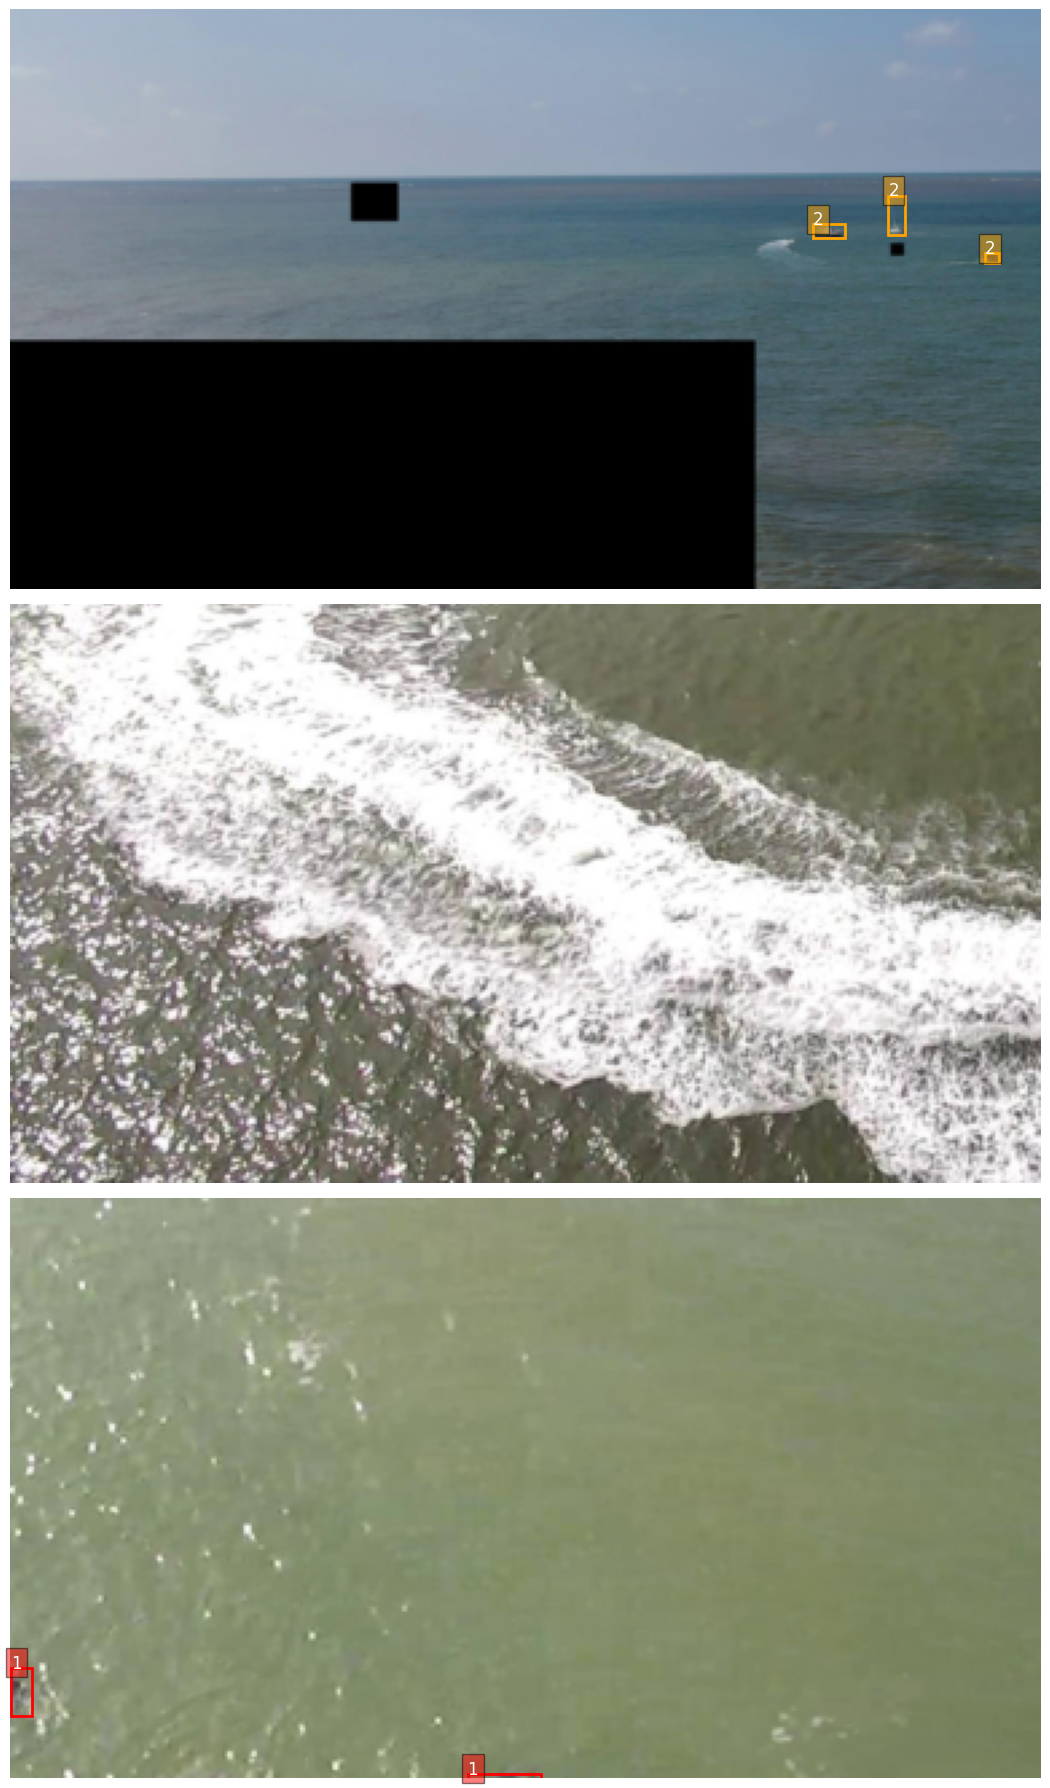

In [24]:
def show_image_with_boxes(img, targets, ax, category_colors):
    """Plot an image with its bounding boxes on an axis object."""
    # Convert tensor image to PIL for display if needed
    if isinstance(img, torch.Tensor):
        img = to_pil_image(img)
        print(img.size)
    ax.imshow(img)

    # Check and plot each bounding box with class-specific color
    if 'boxes' in targets and 'labels' in targets:
        boxes = targets['boxes'].cpu().numpy()
        labels = targets['labels'].cpu().numpy()
        for bbox, label in zip(boxes, labels):
            w = bbox[2]-bbox[0]
            h = bbox[3]-bbox[1]
            color = category_colors.get(label, 'gray')  # Use gray for unmapped classes
            rect = patches.Rectangle((bbox[0], bbox[1]), w, h, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(bbox[0], bbox[1], str(label), color='white', fontsize=12, bbox=dict(facecolor=color, alpha=0.5))

def visualize_samples(data_loader, category_colors, num_samples=20):
    """Visualize a specified number of samples from a DataLoader in a single column."""
    num_rows = num_samples  # All samples in a single column
    num_cols = 1
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 25 * num_rows // 4))  # Adjust height based on rows
    samples_visualized = 0

    for images, targets in data_loader:
        for i, ax in enumerate(axs.flat):
            if samples_visualized >= num_samples:
                break  # Stop after displaying the desired number of samples

            show_image_with_boxes(images[i], targets[i], ax, category_colors)
            ax.axis('off')  # Turn off axis for cleaner look
            samples_visualized += 1

        # If enough samples visualized, break the loop to avoid extra iterations
        if samples_visualized >= num_samples:
            break

    plt.tight_layout()
    plt.show()


# Assuming train_data_loader is defined and loaded correctly
visualize_samples(train_data_loader, category_colors, num_samples=3)


We can see that everything is good, and the corresponding bounding boxes were also perfectly scaled. Next we will move from Data Preparation to Model Preparation which is another crucial aspect of fine-tuning Faster R-CNN or any deep learning training.


**Visualise Prediction**

In [25]:
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

def visualize_predictions(images, outputs, targets, save_dir, epoch, writer):
    create_directory(save_dir)
    figures = []

    for idx, (image, output, target) in enumerate(zip(images, outputs, targets)):
        try:
            image = image.permute(1, 2, 0).cpu().numpy()  # Convert image tensor to numpy array
            image = np.clip(image, 0, 1)  # Clip image values to be in [0, 1] range

            fig, ax = plt.subplots(1, figsize=(8, 8))
            ax.imshow(image)

            # Plot ground truth boxes
            for box, label in zip(target['boxes'], target['labels']):
                box = box.cpu().numpy()
                xmin, ymin, xmax, ymax = box
                color = category_colors[label.item()]
                rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=color, linewidth=2)
                ax.add_patch(rect)
                ax.text(xmin, ymin, f'{classes_to_idx[label.item()]} ({label.item()})', bbox=dict(facecolor=color, alpha=0.5))

            # Plot predicted boxes
            for box, label in zip(output['boxes'], output['labels']):
                box = box.cpu().numpy()
                xmin, ymin, xmax, ymax = box
                rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2)
                ax.add_patch(rect)
                ax.text(xmin, ymin, f'Pred: {label.item()}', bbox=dict(facecolor='red', alpha=0.5))

            ax.axis('off')
            plt.tight_layout()
            save_path = os.path.join(save_dir, f'prediction_epoch_{epoch}_image_{idx}.png')
            plt.savefig(save_path)
            writer.add_figure(f'Predictions/epoch_{epoch}_image_{idx}', fig, epoch)
            figures.append(fig)
            plt.close(fig)
        except Exception as e:
            print(f"Error while visualizing prediction for index {idx}: {e}")
    return figures

**TRAINING CONFIGURATION**

We will fine-tune for 50 epochs and the `best_map` is initialized to `-inf` to guarantee that the first computed evaluation metric will always exceed this value, ensuring the initial model weights are captured as the best baseline.

In [26]:
num_epochs = 50

best_map = -float('inf') # Training loop
# print(best_map)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**MODEL CONFIGURATION**

* We have four detection backbone models trained on the COCO Dataset from torchvision models for fine-tuning Faster R-CNN. We will exploit these pretrained weights to achieve very good detection accuracy within fewer epochs.

* However, there are other Object Detection architectures as well, such as SSD, RetinaNet, etc., if you would like to give them a try.

* To fit in our Google Colab T4 GPU memory, we will choose a lightweight mobilenet v3 large backbone with around 19.4M parameters, 4.49 GFLOPS, and 32.8 Box mAP on the MSCOCO dataset.

* As our dataset contains six classes, we will modify the pretrained classification head’s final layer to reflect the number of classes in SeaDroneSee. We will use an SGD optimizer with a momentum of 0.9, an initial learning rate of 5e-4, and StepLR to adjust the learning rate every total_epochs/2 (i.e., at the 25th epoch for a total of 50 epochs)


<img src='https://www.dropbox.com/scl/fi/pqddd4x1qlmhmg2b60eet/FasterRCNN_backbones.png?rlkey=unsmsbutoo9lm7hpjyulggaif&st=0rm5swg9&dl=1'>

In [27]:
def get_model(num_classes):
    model = detection.fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")

    #Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #Replace pretrained head with new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
    return model

num_classes = 6
model = get_model(num_classes)
model.to(DEVICE)

print(model)
# print(model.fc1(x).size())
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params,lr=0.0005,momentum=0.9,weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=num_epochs//2,
    gamma=0.1
)
scaler = torch.cuda.amp.GradScaler()

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 80.6MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

**TRAINING**

* To save compute and training time, we will use CUDA Automatic Mixed Precision (AMP) with torch.cuda.amp.GradScaler(), which enables mixed precision by using lower precision (16-bit) for some computations while maintaining single precision (32-bit) for critical parts to ensure accuracy.

* We will monitor all our training and validation metrics, as well as validation predictions, using TensorBoard via torch.utils.tensorboard with add_scalar and add_figure. For each batch in the data loader, images and targets are moved to the specified device (either CUDA or CPU). The model is set to train mode, and predictions and losses are computed. The losses are backpropagated, and optimizers and the learning rate scheduler are applied. For multi-GPU training, losses are averaged across all GPUs. This training pipeline effectively uses a metric logger from torchvision utilities to display metrics at the end of each epoch.


In [ ]:
# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='runs/aerial_detection')

def train_one_epoch(model, data_loader, device, optimizer, print_freq, epoch, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Training Epoch {epoch}:"
    model.to(device)

    with tqdm(data_loader, desc=header) as tq:
        lr_scheduler = None
        for i, (images, targets) in enumerate(tq):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.cuda.amp.autocast(enabled=scaler is not None):
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            loss_value = losses.item()

            optimizer.zero_grad()
            if scaler is not None:
                scaler.scale(losses).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                losses.backward()
                optimizer.step()

            if lr_scheduler is not None:
                lr_scheduler.step()

            metric_logger.update(loss=losses, **loss_dict)
            metric_logger.update(lr=optimizer.param_groups[0]["lr"])

            # Update tqdm postfix to display loss on the progress bar
            tq.set_postfix(loss=losses.item(), lr=optimizer.param_groups[0]["lr"])

            # Log losses to TensorBoard
            writer.add_scalar('Loss/train', losses.item(), epoch * len(data_loader) + i)
            for k, v in loss_dict.items():
                writer.add_scalar(f'Loss/train_{k}', v.item(), epoch * len(data_loader) + i)

    print(f"Average Loss: {metric_logger.meters['loss'].global_avg:.4f}")
    writer.add_scalar('Loss/avg_train', metric_logger.meters['loss'].global_avg, epoch)


* Subsequently, we will define the evaluate function by setting the model to evaluation mode. With torch.no_grad, no gradient calculation or weight update occurs. An object detection model is evaluated based on its mAP50 or mAP50-95 (mean Average Precision). For this, the torchmetrics library's MeanAveragePrecision class is useful. We pass the predictions and ground truth from the validation data loader to it.
  
* For simplicity, Average Precision (AP) is the area under the precision-recall curve. Mean Average Precision (mAP) is the average of AP across all detected classes.

*   mAP = 1/n * sum(AP), where n is the number of classes.

* The best model is saved if the current map is better than the best map saved earlier.
Ready, set, train! Let's monitor those metrics in TensorBoard.



In [ ]:
def evaluate(model, data_loader, device, epoch, save_dir):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox")
    total_iou = 0
    total_detections = 0
    header = "Validation:"
    total_steps = len(data_loader)
    samples = []

    with torch.no_grad(), tqdm(total=total_steps, desc=header) as progress_bar:
        for i, (images, targets) in enumerate(data_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)

            # Convert outputs for torchmetrics
            preds = [
                {"boxes": out["boxes"], "scores": out["scores"], "labels": out["labels"]}
                for out in outputs
            ]
            targs = [
                {"boxes": tgt["boxes"], "labels": tgt["labels"]}
                for tgt in targets
            ]

            # Update metric for mAP calculation
            metric.update(preds, targs)

            # Collect samples for visualization (limit to 5)
            if len(samples) < 5:
                for img, out, tgt in zip(images, outputs, targets):
                    samples.append((img, out, tgt))
                    if len(samples) >= 5:
                        break

            progress_bar.update(1)

    # Visualize predictions
    visualize_predictions([s[0] for s in samples], [s[1] for s in samples], [s[2] for s in samples], save_dir, epoch, writer)


    results = metric.compute()
    print("mAP results:")
    print(results)

    # Log mAP to TensorBoard

    for k, v in results.items():
        if v.numel() == 1:  # Single element tensor
            writer.add_scalar(f'mAP/{k}', v.item(), epoch)
        else:  # Multi-element tensor, log each element separately
            for idx, value in enumerate(v):
                writer.add_scalar(f'mAP/{k}_{idx}', value.item(), epoch)
    return results


In [28]:
save_dir = "./prediction_val"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
for epoch in range(num_epochs):
    # Memory Cleanup.
    torch.cuda.empty_cache()
    gc.collect()
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, train_data_loader, DEVICE, optimizer, print_freq=50, epoch=epoch, scaler=scaler)
    # update the learning rate
    # lr_scheduler.step()
    # evaluate on the validation dataset
    results = evaluate(model, val_data_loader, DEVICE, epoch, save_dir='predictions')

    # Save the model checkpoint if it's the best mAP
    current_map = results['map'].item()
    if current_map > best_map:
        best_map = current_map
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_map': best_map,
            'scaler': scaler.state_dict() if scaler is not None else None
        }, f'best_model_checkpoint_epoch_{epoch}.pth')

print("That's it!")
writer.close()

Training Epoch 0:: 100%|█| 1374/1374 [06:05<00:00,  3.76it/s, loss=0.383, lr=0.0


Average Loss: 0.4825


Validation:: 100%|████████████████████████████| 238/238 [00:40<00:00,  5.95it/s]


mAP results:
{'map': tensor(0.2599), 'map_50': tensor(0.5052), 'map_75': tensor(0.2427), 'map_small': tensor(0.2649), 'map_medium': tensor(0.3736), 'map_large': tensor(0.4271), 'mar_1': tensor(0.2503), 'mar_10': tensor(0.3451), 'mar_100': tensor(0.3496), 'mar_small': tensor(0.3459), 'mar_medium': tensor(0.5272), 'mar_large': tensor(0.5322), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 1:: 100%|█| 1374/1374 [05:58<00:00,  3.83it/s, loss=0.391, lr=0.0


Average Loss: 0.3801


Validation:: 100%|████████████████████████████| 238/238 [00:39<00:00,  6.06it/s]


mAP results:
{'map': tensor(0.2939), 'map_50': tensor(0.5650), 'map_75': tensor(0.2736), 'map_small': tensor(0.2980), 'map_medium': tensor(0.4214), 'map_large': tensor(0.4343), 'mar_1': tensor(0.2753), 'mar_10': tensor(0.3749), 'mar_100': tensor(0.3776), 'mar_small': tensor(0.3743), 'mar_medium': tensor(0.5592), 'mar_large': tensor(0.5308), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 2:: 100%|█| 1374/1374 [05:52<00:00,  3.90it/s, loss=0.355, lr=0.0


Average Loss: 0.3850


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.13it/s]


mAP results:
{'map': tensor(0.3130), 'map_50': tensor(0.6020), 'map_75': tensor(0.2913), 'map_small': tensor(0.3168), 'map_medium': tensor(0.4427), 'map_large': tensor(0.4369), 'mar_1': tensor(0.2870), 'mar_10': tensor(0.3942), 'mar_100': tensor(0.3972), 'mar_small': tensor(0.3946), 'mar_medium': tensor(0.5682), 'mar_large': tensor(0.5266), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 3:: 100%|█| 1374/1374 [05:50<00:00,  3.92it/s, loss=0.345, lr=0.0


Average Loss: 0.3846


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.13it/s]


mAP results:
{'map': tensor(0.3270), 'map_50': tensor(0.6224), 'map_75': tensor(0.3013), 'map_small': tensor(0.3316), 'map_medium': tensor(0.4549), 'map_large': tensor(0.4419), 'mar_1': tensor(0.3010), 'mar_10': tensor(0.4099), 'mar_100': tensor(0.4125), 'mar_small': tensor(0.4110), 'mar_medium': tensor(0.5698), 'mar_large': tensor(0.5150), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 4:: 100%|█| 1374/1374 [05:49<00:00,  3.94it/s, loss=0.401, lr=0.0


Average Loss: 0.3891


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.17it/s]


mAP results:
{'map': tensor(0.3321), 'map_50': tensor(0.6379), 'map_75': tensor(0.3094), 'map_small': tensor(0.3369), 'map_medium': tensor(0.4623), 'map_large': tensor(0.4565), 'mar_1': tensor(0.3041), 'mar_10': tensor(0.4147), 'mar_100': tensor(0.4167), 'mar_small': tensor(0.4156), 'mar_medium': tensor(0.5695), 'mar_large': tensor(0.5352), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 5:: 100%|█| 1374/1374 [05:57<00:00,  3.84it/s, loss=0.445, lr=0.0


Average Loss: 0.3903


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.18it/s]


mAP results:
{'map': tensor(0.3411), 'map_50': tensor(0.6498), 'map_75': tensor(0.3128), 'map_small': tensor(0.3448), 'map_medium': tensor(0.4774), 'map_large': tensor(0.4756), 'mar_1': tensor(0.3135), 'mar_10': tensor(0.4247), 'mar_100': tensor(0.4266), 'mar_small': tensor(0.4230), 'mar_medium': tensor(0.5897), 'mar_large': tensor(0.5771), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 6:: 100%|█| 1374/1374 [05:48<00:00,  3.95it/s, loss=0.383, lr=0.0


Average Loss: 0.3947


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.16it/s]


mAP results:
{'map': tensor(0.3459), 'map_50': tensor(0.6586), 'map_75': tensor(0.3187), 'map_small': tensor(0.3481), 'map_medium': tensor(0.4850), 'map_large': tensor(0.4827), 'mar_1': tensor(0.3161), 'mar_10': tensor(0.4303), 'mar_100': tensor(0.4325), 'mar_small': tensor(0.4285), 'mar_medium': tensor(0.5922), 'mar_large': tensor(0.5602), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 7:: 100%|█| 1374/1374 [05:47<00:00,  3.96it/s, loss=0.402, lr=0.0


Average Loss: 0.3947


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.21it/s]


mAP results:
{'map': tensor(0.3484), 'map_50': tensor(0.6699), 'map_75': tensor(0.3177), 'map_small': tensor(0.3515), 'map_medium': tensor(0.4671), 'map_large': tensor(0.4801), 'mar_1': tensor(0.3175), 'mar_10': tensor(0.4281), 'mar_100': tensor(0.4297), 'mar_small': tensor(0.4273), 'mar_medium': tensor(0.5746), 'mar_large': tensor(0.5614), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 8:: 100%|█| 1374/1374 [05:47<00:00,  3.96it/s, loss=0.384, lr=0.0


Average Loss: 0.3963


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.22it/s]


mAP results:
{'map': tensor(0.3524), 'map_50': tensor(0.6729), 'map_75': tensor(0.3226), 'map_small': tensor(0.3538), 'map_medium': tensor(0.4837), 'map_large': tensor(0.4824), 'mar_1': tensor(0.3210), 'mar_10': tensor(0.4355), 'mar_100': tensor(0.4374), 'mar_small': tensor(0.4332), 'mar_medium': tensor(0.5910), 'mar_large': tensor(0.5447), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 9:: 100%|█| 1374/1374 [05:46<00:00,  3.97it/s, loss=0.341, lr=0.0


Average Loss: 0.3972


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.25it/s]


mAP results:
{'map': tensor(0.3554), 'map_50': tensor(0.6699), 'map_75': tensor(0.3268), 'map_small': tensor(0.3565), 'map_medium': tensor(0.4943), 'map_large': tensor(0.4865), 'mar_1': tensor(0.3242), 'mar_10': tensor(0.4359), 'mar_100': tensor(0.4376), 'mar_small': tensor(0.4326), 'mar_medium': tensor(0.6018), 'mar_large': tensor(0.5532), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 10:: 100%|█| 1374/1374 [05:45<00:00,  3.98it/s, loss=0.426, lr=0.


Average Loss: 0.3982


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.23it/s]


mAP results:
{'map': tensor(0.3593), 'map_50': tensor(0.6790), 'map_75': tensor(0.3353), 'map_small': tensor(0.3612), 'map_medium': tensor(0.4974), 'map_large': tensor(0.5005), 'mar_1': tensor(0.3281), 'mar_10': tensor(0.4385), 'mar_100': tensor(0.4398), 'mar_small': tensor(0.4355), 'mar_medium': tensor(0.6049), 'mar_large': tensor(0.5647), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 11:: 100%|█| 1374/1374 [05:45<00:00,  3.98it/s, loss=0.454, lr=0.


Average Loss: 0.4003


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.23it/s]


mAP results:
{'map': tensor(0.3609), 'map_50': tensor(0.6810), 'map_75': tensor(0.3370), 'map_small': tensor(0.3619), 'map_medium': tensor(0.4937), 'map_large': tensor(0.5194), 'mar_1': tensor(0.3300), 'mar_10': tensor(0.4381), 'mar_100': tensor(0.4393), 'mar_small': tensor(0.4348), 'mar_medium': tensor(0.5996), 'mar_large': tensor(0.5765), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 12:: 100%|█| 1374/1374 [05:44<00:00,  3.98it/s, loss=0.366, lr=0.


Average Loss: 0.4022


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.24it/s]


mAP results:
{'map': tensor(0.3672), 'map_50': tensor(0.6917), 'map_75': tensor(0.3428), 'map_small': tensor(0.3687), 'map_medium': tensor(0.4938), 'map_large': tensor(0.4967), 'mar_1': tensor(0.3316), 'mar_10': tensor(0.4463), 'mar_100': tensor(0.4475), 'mar_small': tensor(0.4438), 'mar_medium': tensor(0.5980), 'mar_large': tensor(0.5556), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 13:: 100%|█| 1374/1374 [05:44<00:00,  3.98it/s, loss=0.53, lr=0.0


Average Loss: 0.3986


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.23it/s]


mAP results:
{'map': tensor(0.3646), 'map_50': tensor(0.6773), 'map_75': tensor(0.3385), 'map_small': tensor(0.3667), 'map_medium': tensor(0.4954), 'map_large': tensor(0.5287), 'mar_1': tensor(0.3325), 'mar_10': tensor(0.4410), 'mar_100': tensor(0.4421), 'mar_small': tensor(0.4381), 'mar_medium': tensor(0.6030), 'mar_large': tensor(0.5889), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 14:: 100%|█| 1374/1374 [05:44<00:00,  3.99it/s, loss=0.347, lr=0.


Average Loss: 0.3983


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.20it/s]


mAP results:
{'map': tensor(0.3676), 'map_50': tensor(0.6941), 'map_75': tensor(0.3507), 'map_small': tensor(0.3674), 'map_medium': tensor(0.5020), 'map_large': tensor(0.5248), 'mar_1': tensor(0.3329), 'mar_10': tensor(0.4426), 'mar_100': tensor(0.4435), 'mar_small': tensor(0.4387), 'mar_medium': tensor(0.6047), 'mar_large': tensor(0.5839), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 15:: 100%|█| 1374/1374 [05:43<00:00,  4.00it/s, loss=0.508, lr=0.


Average Loss: 0.4043


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.18it/s]


mAP results:
{'map': tensor(0.3681), 'map_50': tensor(0.6928), 'map_75': tensor(0.3427), 'map_small': tensor(0.3686), 'map_medium': tensor(0.4996), 'map_large': tensor(0.5071), 'mar_1': tensor(0.3346), 'mar_10': tensor(0.4441), 'mar_100': tensor(0.4451), 'mar_small': tensor(0.4402), 'mar_medium': tensor(0.6059), 'mar_large': tensor(0.5725), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 16:: 100%|█| 1374/1374 [05:43<00:00,  4.00it/s, loss=0.332, lr=0.


Average Loss: 0.4006


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.24it/s]


mAP results:
{'map': tensor(0.3717), 'map_50': tensor(0.6984), 'map_75': tensor(0.3450), 'map_small': tensor(0.3728), 'map_medium': tensor(0.4967), 'map_large': tensor(0.5149), 'mar_1': tensor(0.3374), 'mar_10': tensor(0.4476), 'mar_100': tensor(0.4484), 'mar_small': tensor(0.4450), 'mar_medium': tensor(0.6007), 'mar_large': tensor(0.5718), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 17:: 100%|█| 1374/1374 [05:43<00:00,  4.00it/s, loss=0.305, lr=0.


Average Loss: 0.4008


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.23it/s]


mAP results:
{'map': tensor(0.3694), 'map_50': tensor(0.7017), 'map_75': tensor(0.3430), 'map_small': tensor(0.3726), 'map_medium': tensor(0.4892), 'map_large': tensor(0.4961), 'mar_1': tensor(0.3338), 'mar_10': tensor(0.4461), 'mar_100': tensor(0.4469), 'mar_small': tensor(0.4444), 'mar_medium': tensor(0.5954), 'mar_large': tensor(0.5601), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 18:: 100%|█| 1374/1374 [05:43<00:00,  4.00it/s, loss=0.334, lr=0.


Average Loss: 0.3997


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.26it/s]


mAP results:
{'map': tensor(0.3721), 'map_50': tensor(0.6963), 'map_75': tensor(0.3533), 'map_small': tensor(0.3715), 'map_medium': tensor(0.5087), 'map_large': tensor(0.5134), 'mar_1': tensor(0.3357), 'mar_10': tensor(0.4476), 'mar_100': tensor(0.4486), 'mar_small': tensor(0.4439), 'mar_medium': tensor(0.6085), 'mar_large': tensor(0.5788), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 19:: 100%|█| 1374/1374 [05:43<00:00,  4.00it/s, loss=0.262, lr=0.


Average Loss: 0.4005


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.23it/s]


mAP results:
{'map': tensor(0.3768), 'map_50': tensor(0.7028), 'map_75': tensor(0.3601), 'map_small': tensor(0.3773), 'map_medium': tensor(0.5038), 'map_large': tensor(0.5094), 'mar_1': tensor(0.3383), 'mar_10': tensor(0.4502), 'mar_100': tensor(0.4510), 'mar_small': tensor(0.4473), 'mar_medium': tensor(0.6059), 'mar_large': tensor(0.5766), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 20:: 100%|█| 1374/1374 [05:43<00:00,  4.00it/s, loss=0.302, lr=0.


Average Loss: 0.3997


Validation:: 100%|████████████████████████████| 238/238 [00:37<00:00,  6.27it/s]


mAP results:
{'map': tensor(0.3760), 'map_50': tensor(0.7051), 'map_75': tensor(0.3652), 'map_small': tensor(0.3761), 'map_medium': tensor(0.5040), 'map_large': tensor(0.5333), 'mar_1': tensor(0.3403), 'mar_10': tensor(0.4512), 'mar_100': tensor(0.4520), 'mar_small': tensor(0.4471), 'mar_medium': tensor(0.6047), 'mar_large': tensor(0.5984), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 21:: 100%|█| 1374/1374 [05:42<00:00,  4.01it/s, loss=0.391, lr=0.


Average Loss: 0.4020


Validation:: 100%|████████████████████████████| 238/238 [00:37<00:00,  6.28it/s]


mAP results:
{'map': tensor(0.3828), 'map_50': tensor(0.7099), 'map_75': tensor(0.3635), 'map_small': tensor(0.3843), 'map_medium': tensor(0.5087), 'map_large': tensor(0.5047), 'mar_1': tensor(0.3447), 'mar_10': tensor(0.4547), 'mar_100': tensor(0.4554), 'mar_small': tensor(0.4522), 'mar_medium': tensor(0.6081), 'mar_large': tensor(0.5697), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 22:: 100%|█| 1374/1374 [05:42<00:00,  4.01it/s, loss=0.403, lr=0.


Average Loss: 0.3987


Validation:: 100%|████████████████████████████| 238/238 [00:37<00:00,  6.27it/s]


mAP results:
{'map': tensor(0.3817), 'map_50': tensor(0.7135), 'map_75': tensor(0.3591), 'map_small': tensor(0.3833), 'map_medium': tensor(0.5010), 'map_large': tensor(0.4978), 'mar_1': tensor(0.3439), 'mar_10': tensor(0.4549), 'mar_100': tensor(0.4558), 'mar_small': tensor(0.4535), 'mar_medium': tensor(0.6011), 'mar_large': tensor(0.5589), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 23:: 100%|█| 1374/1374 [05:42<00:00,  4.01it/s, loss=0.514, lr=0.


Average Loss: 0.4036


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.26it/s]


mAP results:
{'map': tensor(0.3797), 'map_50': tensor(0.7069), 'map_75': tensor(0.3598), 'map_small': tensor(0.3805), 'map_medium': tensor(0.5043), 'map_large': tensor(0.5036), 'mar_1': tensor(0.3422), 'mar_10': tensor(0.4557), 'mar_100': tensor(0.4567), 'mar_small': tensor(0.4535), 'mar_medium': tensor(0.6030), 'mar_large': tensor(0.5720), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 24:: 100%|█| 1374/1374 [05:42<00:00,  4.01it/s, loss=0.302, lr=0.


Average Loss: 0.3994


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.21it/s]


mAP results:
{'map': tensor(0.3798), 'map_50': tensor(0.7123), 'map_75': tensor(0.3500), 'map_small': tensor(0.3827), 'map_medium': tensor(0.4956), 'map_large': tensor(0.4823), 'mar_1': tensor(0.3414), 'mar_10': tensor(0.4532), 'mar_100': tensor(0.4540), 'mar_small': tensor(0.4528), 'mar_medium': tensor(0.5923), 'mar_large': tensor(0.5572), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 25:: 100%|█| 1374/1374 [05:42<00:00,  4.01it/s, loss=0.432, lr=0.


Average Loss: 0.3974


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.24it/s]


mAP results:
{'map': tensor(0.3824), 'map_50': tensor(0.7142), 'map_75': tensor(0.3696), 'map_small': tensor(0.3851), 'map_medium': tensor(0.5008), 'map_large': tensor(0.5030), 'mar_1': tensor(0.3444), 'mar_10': tensor(0.4566), 'mar_100': tensor(0.4574), 'mar_small': tensor(0.4541), 'mar_medium': tensor(0.6027), 'mar_large': tensor(0.5665), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 26:: 100%|█| 1374/1374 [05:41<00:00,  4.02it/s, loss=0.411, lr=0.


Average Loss: 0.4013


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.25it/s]


mAP results:
{'map': tensor(0.3797), 'map_50': tensor(0.7105), 'map_75': tensor(0.3560), 'map_small': tensor(0.3813), 'map_medium': tensor(0.4976), 'map_large': tensor(0.4987), 'mar_1': tensor(0.3405), 'mar_10': tensor(0.4557), 'mar_100': tensor(0.4567), 'mar_small': tensor(0.4544), 'mar_medium': tensor(0.5922), 'mar_large': tensor(0.5656), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 27:: 100%|█| 1374/1374 [05:42<00:00,  4.01it/s, loss=0.367, lr=0.


Average Loss: 0.3948


Validation:: 100%|████████████████████████████| 238/238 [00:37<00:00,  6.27it/s]


mAP results:
{'map': tensor(0.3851), 'map_50': tensor(0.7095), 'map_75': tensor(0.3607), 'map_small': tensor(0.3879), 'map_medium': tensor(0.4982), 'map_large': tensor(0.5055), 'mar_1': tensor(0.3476), 'mar_10': tensor(0.4598), 'mar_100': tensor(0.4606), 'mar_small': tensor(0.4589), 'mar_medium': tensor(0.5982), 'mar_large': tensor(0.5780), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 28:: 100%|█| 1374/1374 [05:41<00:00,  4.02it/s, loss=0.446, lr=0.


Average Loss: 0.4004


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.26it/s]


mAP results:
{'map': tensor(0.3838), 'map_50': tensor(0.7129), 'map_75': tensor(0.3667), 'map_small': tensor(0.3877), 'map_medium': tensor(0.4961), 'map_large': tensor(0.4940), 'mar_1': tensor(0.3437), 'mar_10': tensor(0.4551), 'mar_100': tensor(0.4559), 'mar_small': tensor(0.4552), 'mar_medium': tensor(0.5943), 'mar_large': tensor(0.5577), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 29:: 100%|█| 1374/1374 [05:42<00:00,  4.02it/s, loss=0.352, lr=0.


Average Loss: 0.3961


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.26it/s]


mAP results:
{'map': tensor(0.3813), 'map_50': tensor(0.7088), 'map_75': tensor(0.3506), 'map_small': tensor(0.3865), 'map_medium': tensor(0.4885), 'map_large': tensor(0.4860), 'mar_1': tensor(0.3410), 'mar_10': tensor(0.4530), 'mar_100': tensor(0.4537), 'mar_small': tensor(0.4538), 'mar_medium': tensor(0.5880), 'mar_large': tensor(0.5396), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 30:: 100%|█| 1374/1374 [05:42<00:00,  4.02it/s, loss=0.384, lr=0.


Average Loss: 0.3970


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.21it/s]


mAP results:
{'map': tensor(0.3831), 'map_50': tensor(0.7124), 'map_75': tensor(0.3610), 'map_small': tensor(0.3854), 'map_medium': tensor(0.4956), 'map_large': tensor(0.4784), 'mar_1': tensor(0.3432), 'mar_10': tensor(0.4545), 'mar_100': tensor(0.4554), 'mar_small': tensor(0.4538), 'mar_medium': tensor(0.5945), 'mar_large': tensor(0.5437), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 31:: 100%|█| 1374/1374 [05:41<00:00,  4.02it/s, loss=0.481, lr=0.


Average Loss: 0.3967


Validation:: 100%|████████████████████████████| 238/238 [00:37<00:00,  6.26it/s]


mAP results:
{'map': tensor(0.3818), 'map_50': tensor(0.7127), 'map_75': tensor(0.3528), 'map_small': tensor(0.3854), 'map_medium': tensor(0.4891), 'map_large': tensor(0.4938), 'mar_1': tensor(0.3417), 'mar_10': tensor(0.4525), 'mar_100': tensor(0.4530), 'mar_small': tensor(0.4510), 'mar_medium': tensor(0.5919), 'mar_large': tensor(0.5621), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 32:: 100%|█| 1374/1374 [05:41<00:00,  4.02it/s, loss=0.364, lr=0.


Average Loss: 0.3923


Validation:: 100%|████████████████████████████| 238/238 [00:37<00:00,  6.29it/s]


mAP results:
{'map': tensor(0.3828), 'map_50': tensor(0.7038), 'map_75': tensor(0.3708), 'map_small': tensor(0.3867), 'map_medium': tensor(0.4922), 'map_large': tensor(0.4867), 'mar_1': tensor(0.3443), 'mar_10': tensor(0.4524), 'mar_100': tensor(0.4530), 'mar_small': tensor(0.4517), 'mar_medium': tensor(0.5931), 'mar_large': tensor(0.5513), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 33:: 100%|█| 1374/1374 [05:41<00:00,  4.02it/s, loss=0.388, lr=0.


Average Loss: 0.3930


Validation:: 100%|████████████████████████████| 238/238 [00:37<00:00,  6.29it/s]


mAP results:
{'map': tensor(0.3796), 'map_50': tensor(0.7108), 'map_75': tensor(0.3464), 'map_small': tensor(0.3836), 'map_medium': tensor(0.4845), 'map_large': tensor(0.4624), 'mar_1': tensor(0.3416), 'mar_10': tensor(0.4550), 'mar_100': tensor(0.4560), 'mar_small': tensor(0.4560), 'mar_medium': tensor(0.5820), 'mar_large': tensor(0.5193), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 34:: 100%|█| 1374/1374 [05:41<00:00,  4.02it/s, loss=0.397, lr=0.


Average Loss: 0.3910


Validation:: 100%|████████████████████████████| 238/238 [00:37<00:00,  6.29it/s]


mAP results:
{'map': tensor(0.3812), 'map_50': tensor(0.7111), 'map_75': tensor(0.3563), 'map_small': tensor(0.3847), 'map_medium': tensor(0.4948), 'map_large': tensor(0.4800), 'mar_1': tensor(0.3438), 'mar_10': tensor(0.4548), 'mar_100': tensor(0.4555), 'mar_small': tensor(0.4538), 'mar_medium': tensor(0.5960), 'mar_large': tensor(0.5436), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 35:: 100%|█| 1374/1374 [05:41<00:00,  4.02it/s, loss=0.379, lr=0.


Average Loss: 0.3902


Validation:: 100%|████████████████████████████| 238/238 [00:37<00:00,  6.27it/s]


mAP results:
{'map': tensor(0.3837), 'map_50': tensor(0.7127), 'map_75': tensor(0.3643), 'map_small': tensor(0.3870), 'map_medium': tensor(0.4900), 'map_large': tensor(0.4702), 'mar_1': tensor(0.3421), 'mar_10': tensor(0.4543), 'mar_100': tensor(0.4552), 'mar_small': tensor(0.4543), 'mar_medium': tensor(0.5907), 'mar_large': tensor(0.5366), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 36:: 100%|█| 1374/1374 [05:41<00:00,  4.02it/s, loss=0.449, lr=0.


Average Loss: 0.3908


Validation:: 100%|████████████████████████████| 238/238 [00:37<00:00,  6.28it/s]


mAP results:
{'map': tensor(0.3824), 'map_50': tensor(0.7099), 'map_75': tensor(0.3555), 'map_small': tensor(0.3858), 'map_medium': tensor(0.4917), 'map_large': tensor(0.4657), 'mar_1': tensor(0.3429), 'mar_10': tensor(0.4562), 'mar_100': tensor(0.4569), 'mar_small': tensor(0.4561), 'mar_medium': tensor(0.5897), 'mar_large': tensor(0.5303), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 37:: 100%|█| 1374/1374 [05:41<00:00,  4.02it/s, loss=0.431, lr=0.


Average Loss: 0.3897


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.23it/s]


mAP results:
{'map': tensor(0.3803), 'map_50': tensor(0.7180), 'map_75': tensor(0.3515), 'map_small': tensor(0.3841), 'map_medium': tensor(0.4778), 'map_large': tensor(0.4735), 'mar_1': tensor(0.3425), 'mar_10': tensor(0.4555), 'mar_100': tensor(0.4562), 'mar_small': tensor(0.4555), 'mar_medium': tensor(0.5831), 'mar_large': tensor(0.5455), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 38:: 100%|█| 1374/1374 [05:41<00:00,  4.02it/s, loss=0.372, lr=0.


Average Loss: 0.3860


Validation:: 100%|████████████████████████████| 238/238 [00:37<00:00,  6.27it/s]


mAP results:
{'map': tensor(0.3784), 'map_50': tensor(0.7116), 'map_75': tensor(0.3520), 'map_small': tensor(0.3834), 'map_medium': tensor(0.4813), 'map_large': tensor(0.4671), 'mar_1': tensor(0.3397), 'mar_10': tensor(0.4514), 'mar_100': tensor(0.4525), 'mar_small': tensor(0.4520), 'mar_medium': tensor(0.5830), 'mar_large': tensor(0.5414), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 39:: 100%|█| 1374/1374 [05:41<00:00,  4.03it/s, loss=0.313, lr=0.


Average Loss: 0.3893


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.23it/s]


mAP results:
{'map': tensor(0.3827), 'map_50': tensor(0.7135), 'map_75': tensor(0.3603), 'map_small': tensor(0.3886), 'map_medium': tensor(0.4712), 'map_large': tensor(0.4861), 'mar_1': tensor(0.3416), 'mar_10': tensor(0.4533), 'mar_100': tensor(0.4539), 'mar_small': tensor(0.4543), 'mar_medium': tensor(0.5757), 'mar_large': tensor(0.5527), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 40:: 100%|█| 1374/1374 [05:41<00:00,  4.03it/s, loss=0.407, lr=0.


Average Loss: 0.3867


Validation:: 100%|████████████████████████████| 238/238 [00:37<00:00,  6.29it/s]


mAP results:
{'map': tensor(0.3808), 'map_50': tensor(0.7058), 'map_75': tensor(0.3598), 'map_small': tensor(0.3852), 'map_medium': tensor(0.4760), 'map_large': tensor(0.4706), 'mar_1': tensor(0.3418), 'mar_10': tensor(0.4525), 'mar_100': tensor(0.4530), 'mar_small': tensor(0.4521), 'mar_medium': tensor(0.5784), 'mar_large': tensor(0.5378), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 41:: 100%|█| 1374/1374 [05:41<00:00,  4.03it/s, loss=0.34, lr=0.0


Average Loss: 0.3881


Validation:: 100%|████████████████████████████| 238/238 [00:37<00:00,  6.29it/s]


mAP results:
{'map': tensor(0.3815), 'map_50': tensor(0.7114), 'map_75': tensor(0.3577), 'map_small': tensor(0.3867), 'map_medium': tensor(0.4852), 'map_large': tensor(0.4759), 'mar_1': tensor(0.3441), 'mar_10': tensor(0.4547), 'mar_100': tensor(0.4553), 'mar_small': tensor(0.4554), 'mar_medium': tensor(0.5890), 'mar_large': tensor(0.5445), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 42:: 100%|█| 1374/1374 [05:41<00:00,  4.03it/s, loss=0.404, lr=0.


Average Loss: 0.3838


Validation:: 100%|████████████████████████████| 238/238 [00:37<00:00,  6.28it/s]


mAP results:
{'map': tensor(0.3798), 'map_50': tensor(0.7166), 'map_75': tensor(0.3463), 'map_small': tensor(0.3854), 'map_medium': tensor(0.4770), 'map_large': tensor(0.4780), 'mar_1': tensor(0.3419), 'mar_10': tensor(0.4523), 'mar_100': tensor(0.4531), 'mar_small': tensor(0.4531), 'mar_medium': tensor(0.5793), 'mar_large': tensor(0.5499), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 43:: 100%|█| 1374/1374 [05:41<00:00,  4.02it/s, loss=0.326, lr=0.


Average Loss: 0.3830


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.25it/s]


mAP results:
{'map': tensor(0.3799), 'map_50': tensor(0.7171), 'map_75': tensor(0.3541), 'map_small': tensor(0.3841), 'map_medium': tensor(0.4750), 'map_large': tensor(0.4745), 'mar_1': tensor(0.3427), 'mar_10': tensor(0.4564), 'mar_100': tensor(0.4571), 'mar_small': tensor(0.4570), 'mar_medium': tensor(0.5814), 'mar_large': tensor(0.5407), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 44:: 100%|█| 1374/1374 [05:41<00:00,  4.03it/s, loss=0.333, lr=0.


Average Loss: 0.3828


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.26it/s]


mAP results:
{'map': tensor(0.3832), 'map_50': tensor(0.7179), 'map_75': tensor(0.3628), 'map_small': tensor(0.3883), 'map_medium': tensor(0.4722), 'map_large': tensor(0.4684), 'mar_1': tensor(0.3445), 'mar_10': tensor(0.4589), 'mar_100': tensor(0.4595), 'mar_small': tensor(0.4590), 'mar_medium': tensor(0.5766), 'mar_large': tensor(0.5421), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 45:: 100%|█| 1374/1374 [05:41<00:00,  4.03it/s, loss=0.27, lr=0.0


Average Loss: 0.3807


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.19it/s]


mAP results:
{'map': tensor(0.3801), 'map_50': tensor(0.7157), 'map_75': tensor(0.3519), 'map_small': tensor(0.3848), 'map_medium': tensor(0.4722), 'map_large': tensor(0.4659), 'mar_1': tensor(0.3439), 'mar_10': tensor(0.4569), 'mar_100': tensor(0.4577), 'mar_small': tensor(0.4570), 'mar_medium': tensor(0.5796), 'mar_large': tensor(0.5406), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 46:: 100%|█| 1374/1374 [05:40<00:00,  4.03it/s, loss=0.489, lr=0.


Average Loss: 0.3820


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.25it/s]


mAP results:
{'map': tensor(0.3780), 'map_50': tensor(0.7104), 'map_75': tensor(0.3507), 'map_small': tensor(0.3818), 'map_medium': tensor(0.4745), 'map_large': tensor(0.4721), 'mar_1': tensor(0.3429), 'mar_10': tensor(0.4545), 'mar_100': tensor(0.4552), 'mar_small': tensor(0.4539), 'mar_medium': tensor(0.5814), 'mar_large': tensor(0.5500), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 47:: 100%|█| 1374/1374 [05:41<00:00,  4.03it/s, loss=0.394, lr=0.


Average Loss: 0.3802


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.24it/s]


mAP results:
{'map': tensor(0.3771), 'map_50': tensor(0.7135), 'map_75': tensor(0.3471), 'map_small': tensor(0.3837), 'map_medium': tensor(0.4642), 'map_large': tensor(0.4714), 'mar_1': tensor(0.3414), 'mar_10': tensor(0.4527), 'mar_100': tensor(0.4534), 'mar_small': tensor(0.4544), 'mar_medium': tensor(0.5656), 'mar_large': tensor(0.5444), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 48:: 100%|█| 1374/1374 [05:41<00:00,  4.03it/s, loss=0.383, lr=0.


Average Loss: 0.3795


Validation:: 100%|████████████████████████████| 238/238 [00:38<00:00,  6.12it/s]


mAP results:
{'map': tensor(0.3773), 'map_50': tensor(0.7143), 'map_75': tensor(0.3498), 'map_small': tensor(0.3836), 'map_medium': tensor(0.4626), 'map_large': tensor(0.4733), 'mar_1': tensor(0.3422), 'mar_10': tensor(0.4561), 'mar_100': tensor(0.4569), 'mar_small': tensor(0.4580), 'mar_medium': tensor(0.5645), 'mar_large': tensor(0.5500), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}


Training Epoch 49:: 100%|█| 1374/1374 [05:49<00:00,  3.93it/s, loss=0.344, lr=0.


Average Loss: 0.3764


Validation:: 100%|████████████████████████████| 238/238 [00:39<00:00,  6.06it/s]


mAP results:
{'map': tensor(0.3811), 'map_50': tensor(0.7148), 'map_75': tensor(0.3492), 'map_small': tensor(0.3854), 'map_medium': tensor(0.4692), 'map_large': tensor(0.4600), 'mar_1': tensor(0.3433), 'mar_10': tensor(0.4558), 'mar_100': tensor(0.4564), 'mar_small': tensor(0.4562), 'mar_medium': tensor(0.5725), 'mar_large': tensor(0.5369), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}
That's it!


<div style="text-align: center">
  <img src="https://www.dropbox.com/scl/fi/1i8f2eq9oi83jzq6to22k/Mobilenet_v3_large_logs.png?rlkey=zp0dfmolguaxgj5xgp85guseo&st=kij9f8tb&dl=1" alt="Image" >
</div>




* Now let’s have a closer look at the logs. The metric results are pretty decent for a lightweight model that fits in our Colab T4 GPU. From fine-tuning FasterRCNN with a mobilenet v3 large backbone, we achieved the highest mAP50-95 (mAP) of 38.32 and mAP50 (mAP@IOU=0.5) of  71.24 within four epochs.


* We have also fine-tuned FasterRCNN with a Resnet50 v2 backbone with 43.7 M parameters, 280.37 GFLOPS and achieved an mAP@IOU=0.5-0.95  of 49.88 , mAP@IOU=0.5 of 84.12 with the same training configuration and data loaders on a RTX 3080Ti i7-13700K with 12 cores machine. This is indeed very impressive.
Checkout our other notebook provided.



## **Load Checkpoint**

Let’s load the best model checkpoint and adjust the box_nms_thresh of 0.3 as a postprocessing step to avoid overlapping bounding boxes from the same class instances. As we will use our fine-tuned FasterRCNN model, the pretrained=False argument is passed. The model’s state dictionary passes checks across all the layers, and for inference the model is set to eval mode

In [31]:
checkpoint_path = "SeaDroneSee/model_ckpt/Mobilenet_5e-4_best_model_checkpoint_epoch_27.pth"
# Function to load the trained model
def load_model(checkpoint_path, device):
    model = detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=False, num_classes=len(classes_to_idx),box_nms_thresh=0.3)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

In [32]:
# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_model(checkpoint_path, device)

Let’s define some utilities to visualize the predictions and save the results to the desired output directory. The show_image_with_boxes function takes the image tensor and prediction bounding boxes and converts them to a PIL object.

In [33]:
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

def show_image_with_boxes(img, targets, ax, category_colors):
    """Plot an image with its bounding boxes on an axis object."""
    # Convert tensor image to PIL for display if needed
    if isinstance(img, torch.Tensor):
        img = to_pil_image(img)
    ax.imshow(img)

    # Check and plot each bounding box with class-specific color
    if 'boxes' in targets and 'labels' in targets and 'scores' in targets:
        boxes = targets['boxes'].cpu().numpy()
        labels = targets['labels'].cpu().numpy()
        scores = targets['scores'].cpu().numpy()
        for bbox, label, score in zip(boxes, labels, scores):
            if score >= 0.5:  # Only show boxes with confidence score >= 0.5
                w = bbox[2] - bbox[0]
                h = bbox[3] - bbox[1]
                color = category_colors.get(label, 'gray')  # Use gray for unmapped classes
                rect = patches.Rectangle((bbox[0], bbox[1]), w, h, linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                ax.text(bbox[0], bbox[1], f'{classes_to_idx[label]}', color='white', fontsize=8, bbox=dict(facecolor=color, alpha=0.5))

def visualize_samples(images, outputs, category_colors, num_samples=10):
    """Visualize a specified number of samples from a DataLoader in a single column."""
    num_rows = num_samples  # All samples in a single column
    num_cols = 1
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 25 * num_rows // 4))  # Adjust height based on rows

    for idx, (img, output) in enumerate(zip(images, outputs)):
        if idx >= num_samples:
            break  # Stop after displaying the desired number of samples

        show_image_with_boxes(img.cpu(), output, axs[idx], category_colors)
        axs[idx].axis('off')  # Turn off axis for cleaner look

    plt.tight_layout()
    plt.show()


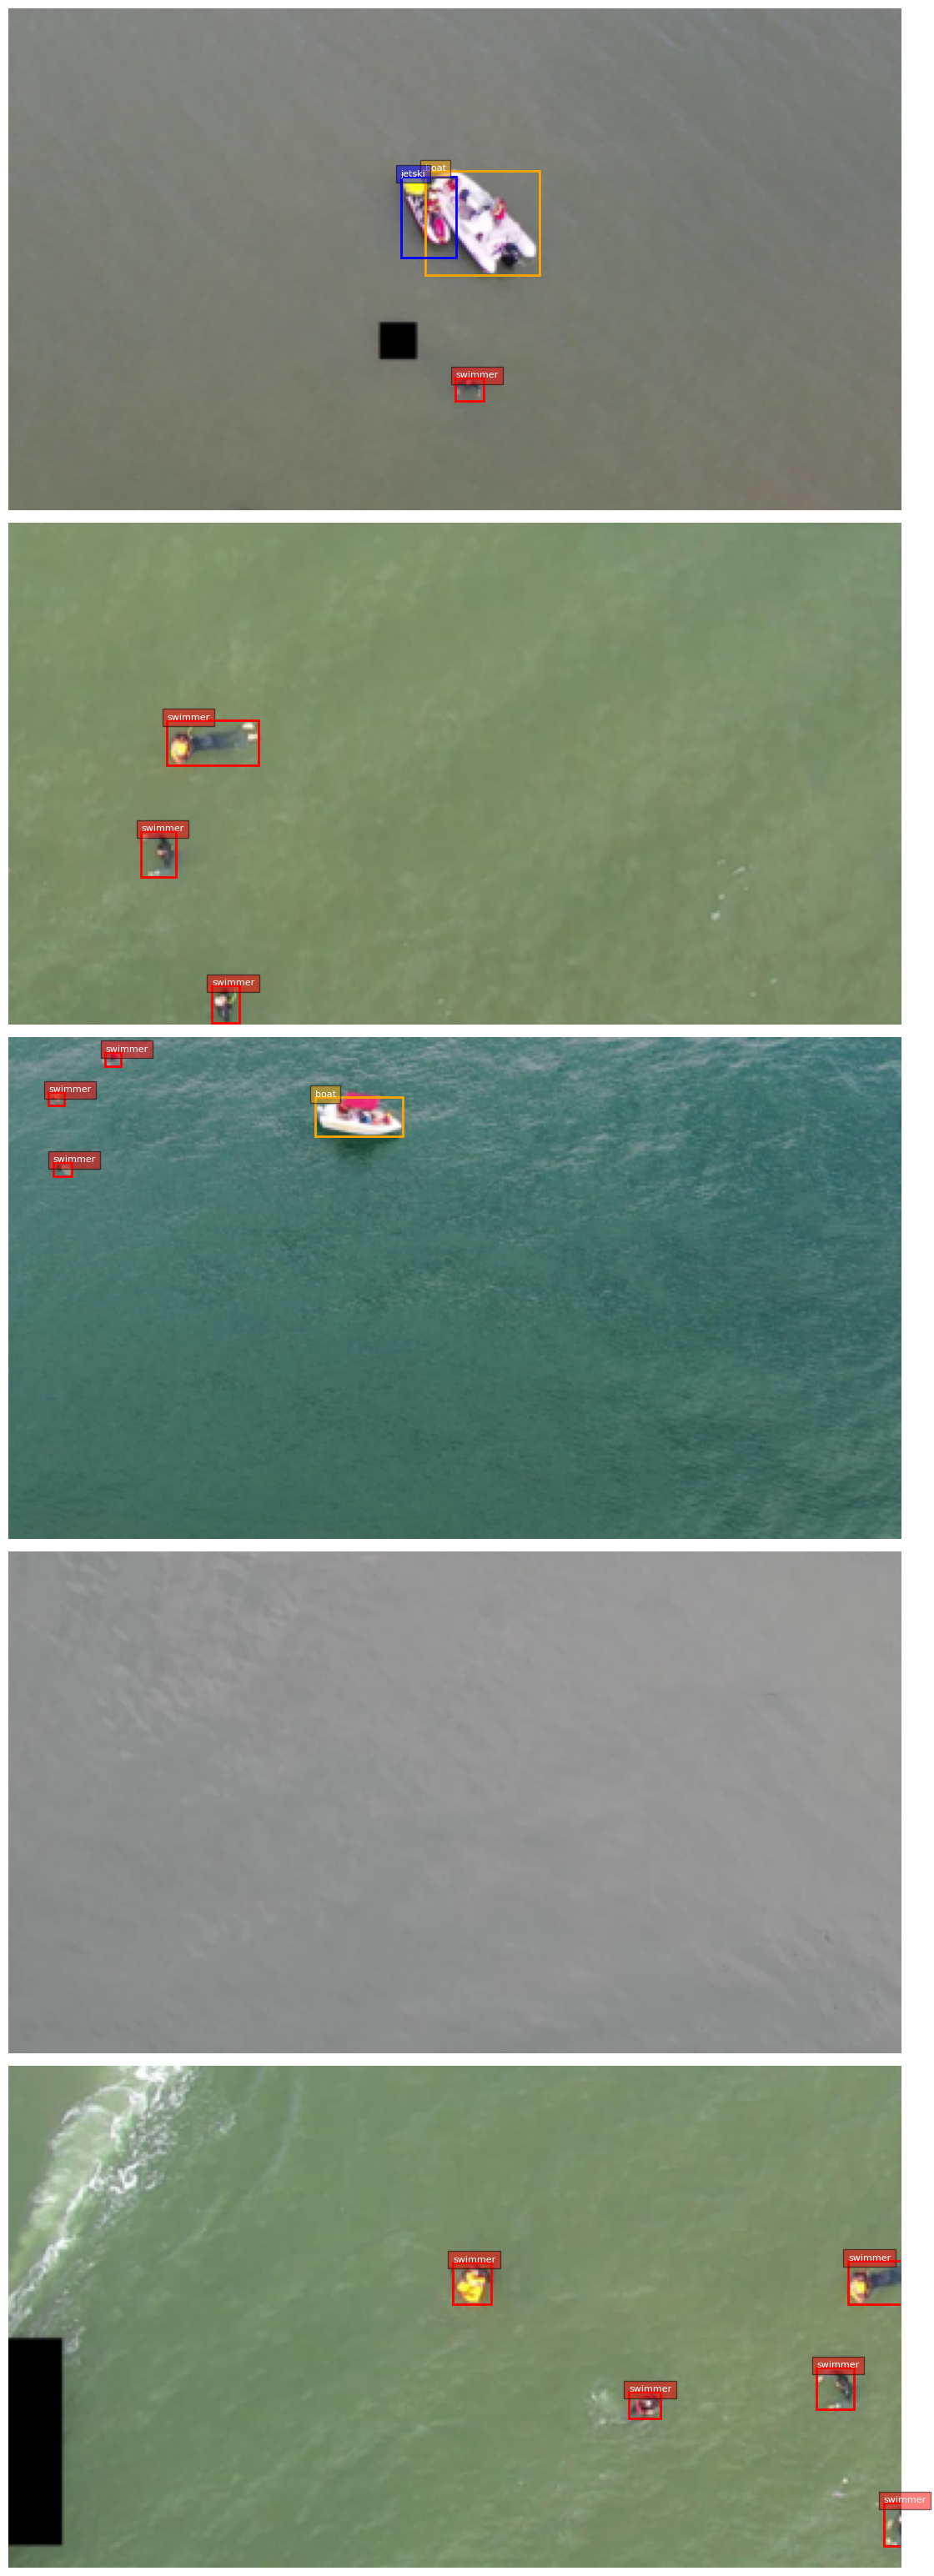

In [35]:
# Perform predictions and visualize
images = []
outputs = []
with torch.no_grad():
    for i, (image_batch, _) in enumerate(val_data_loader):
        if len(images) >= 10:
            break
        for image in image_batch:
            if len(images) >= 10:
                break
            image = image.to(device)
            output = model([image])
            if len(output) > 0:  # Ensure there is at least one prediction
                images.append(image)
                outputs.append({k: v for k, v in output[0].items()})

# Visualize the predictions
visualize_samples(images, outputs, category_colors, num_samples=5)

We can see that fine-tuning Faster R-CNN with patch results is good; it captures even very small instances. 

## **Test Images**

In [111]:
# Example usage
output_dir = 'SeaDroneSee/patches_test'
os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

In [108]:
def check_and_rotate_image(image):
    """Rotate the image if its height is greater than its width and return the image and a flag indicating rotation."""
    width, height = image.size
    if height > width:
        image = image.rotate(90, expand=True)  # Rotates 90 counter-clockwise
        return image, True
    return image, False

In [117]:
def create_patches(image, output_dir, image_filename, overlap_ratio=0.2):
    """Create image patches and handle image rotation if necessary."""
    image, was_rotated = check_and_rotate_image(image)
    width, height = image.size

    patch_width = int(width / 2)
    patch_height = int(height / 2)
    overlap_width = int(patch_width * overlap_ratio)
    overlap_height = int(patch_height * overlap_ratio)

    patches = []
    for i in range(2):  # Three rows
        for j in range(2):  # Three columns
            left = i * (patch_width - overlap_width)
            top = j * (patch_height - overlap_height)
            right = left + patch_width
            bottom = top + patch_height
            patch = image.crop((left, top, right, bottom))
            patch_filename = f'{os.path.splitext(image_filename)[0]}_{i}_{j}.jpg'
            patch_path = os.path.join(output_dir, patch_filename)
            patch.save(patch_path)
            patches.append((patch_filename, left, top, right, bottom, was_rotated))

    return patches

image_path = 'SeaDroneSee/test/1669.jpg'
img_filename = os.path.basename(image_path)
img_filename_temp = img_filename.split('.')[0]
img = Image.open(image_path)
create_patches(img, output_dir, img_filename, overlap_ratio=0.2)


[('1669_0_0.jpg', 0, 0, 2728, 1816, False),
 ('1669_0_1.jpg', 0, 1453, 2728, 3269, False),
 ('1669_1_0.jpg', 2183, 0, 4911, 1816, False),
 ('1669_1_1.jpg', 2183, 1453, 4911, 3269, False)]

## With Patches

In [121]:
def get_transform():
    transforms = []
    transforms.append(Tv2.ToDtype(torch.float, scale=True))
    transforms.append(Tv2.ToPureTensor())
    return Tv2.Compose(transforms)


# Function to show image with bounding boxes and save it to disk
def show_image_with_boxes(img, targets, category_colors, classes_to_idx, output_path):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img)
    boxes = targets['boxes'].cpu().numpy()
    labels = targets['labels'].cpu().numpy()
    scores = targets['scores'].cpu().numpy()
    for bbox, label, score in zip(boxes, labels, scores):
        if score >= 0.3:  # Only show boxes with confidence score >= 0.3
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]
            color = category_colors.get(label, 'gray')  # Use gray for unmapped classes
            rect = patches.Rectangle((bbox[0], bbox[1]), w, h, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            # ax.text(bbox[0], bbox[1], f'{classes_to_idx[label]}: {score:.2f}', color='white', fontsize=12, bbox=dict(facecolor=color, alpha=0.5))
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    # plt.close()

# Function to predict and visualize the output for a single image
def predict_and_visualize(image_path, model, device, category_colors, classes_to_idx, output_path):
    # Load and transform the image
    transforms = get_transform()

    img = PIL.Image.open(image_path).convert("RGB")
    img = img.resize((382, 216), PIL.Image.BILINEAR)  # Resize the image
    # print(img.size)
    img_tensor = F.to_tensor(img)
    img_trans = transforms(img_tensor).to("cuda:0")


    # Perform prediction
    with torch.no_grad():
        output = model(torch.unsqueeze(img_trans,dim=0))[0]

    # Visualize and save the output
    show_image_with_boxes(img, output, category_colors, classes_to_idx, output_path)

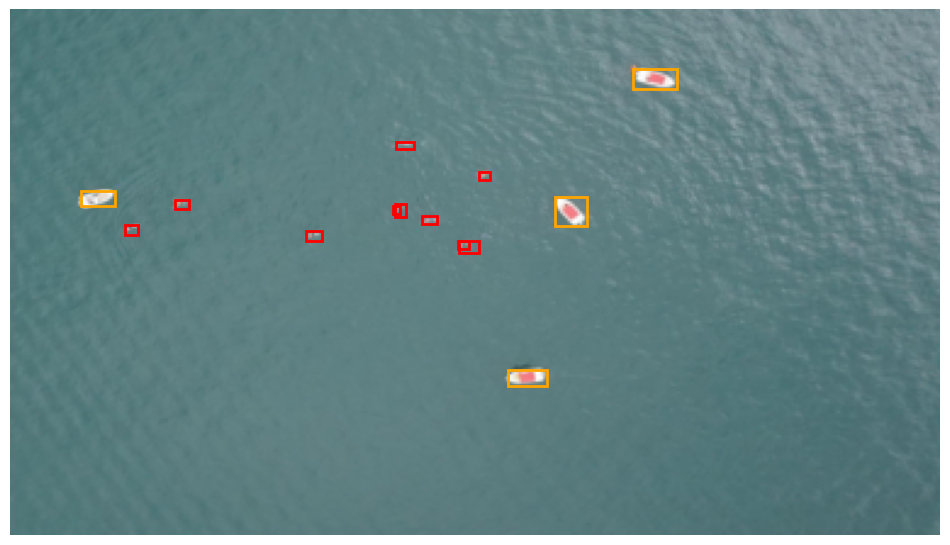

In [123]:
# Path to the image you want to predict
image_path = f'SeaDroneSee/patches_test/{img_filename_temp}_1_1.jpg'

os.makedirs('SeaDroneSee/patches_test/outputs', exist_ok=True)  # Ensure the output directory exists
# Path to save the output image
output_path = f'SeaDroneSee/patches_test/outputs/{img_filename_temp}_1_1_patch_out.jpg'

# Predict and visualize the output for the single image
predict_and_visualize(image_path, model, device, category_colors, classes_to_idx, output_path)


### **Key Takeaways**

**Patch Work Magic**

We split training images into patches, letting it to focus on details. This trick helped it see tiny objects much better. Even without SAHI's help, our fine-tuned Faster R-CNN is practically like eagle eyed, matching SAHI's results almost perfectly.



**SAHI to the Rescue**

Additionally integrating our fine-tuned Faster R-CNN model with SAHI has significantly boosted detection accuracy. SAHI's advanced technique of slicing images into smaller sections was a game-changer, effectively reducing false positives and achieving near-perfect bounding box instances. This combination showcases the powerful synergy of data preparation and robust post processing.


**Data is the King**

Our experiments have highlighted the critical importance of data preparation and preprocessing and demonstrates the value of thoughtful data augmentation.  It's all about the groundwork!
